# Fusion of Sentinel-2 NDVI with ESA Global Land Cover

In [1]:
import os
import yaml
from munch import munchify

In [2]:
# define repo name and get root working directory
repo = 'process-api'
root_path = os.getcwd()[ 0 : os.getcwd().find( repo ) + len ( repo )]
root_path

'C:\\Users\\crwil\\Documents\\GitHub\\sentinelhub\\process-api'

In [3]:
# get path to configuration files
cfg_path = os.path.join( root_path, 'cfg' )
cfg_path = os.path.join( cfg_path, 'fusion' )
cfg_path

'C:\\Users\\crwil\\Documents\\GitHub\\sentinelhub\\process-api\\cfg\\fusion'

In [4]:
# get pathname to configuration file
cfg_file = os.path.join( cfg_path, 's2-lcc-ndvi.yml' )

In [5]:
# print contents of configuration file
with open( cfg_file ) as f:
    print ( f.read() )

request:
    evalscript: |
                //VERSION=3
                function setup() {
                    return {
                        input: [ {
                            datasource: "s2_l2a",
                            bands: [ "B04", "B08", "SCL" ],
                            units: [ "DN", "DN", "DN" ]
                        },
                        {
                            datasource: "glc",
                            bands: ["Discrete_Classification_map"],
                            units: [ "DN" ] 
                        } ],
                        output: [{ // this is now an array since there are multiple output objects
                          id: "NDVI",
                          bands: 4,
                          sampleType: "FLOAT32"
                        }, 
                        {
                          id: "LCC",
                          bands: 1,
                          sampleType: "FLOAT32"
                        } ]
              

In [6]:
# load cfg file using yaml parser
with open( cfg_file, 'r' ) as f:
    config = munchify( yaml.safe_load( f ) )

In [7]:
# define min and max latlons
coords = -3, 51, -2, 52
resolution = 50

In [8]:
# create instance of shclient class
from processapi import Client
#client = Client( config )
client = Client( config, base_url='https://creodias.sentinel-hub.com' )

In [9]:
# get utm bbox
bbox = client.getBoundingBox( coords )
print ( bbox, bbox.crs.value )

499999.99999999936,5649824.888255088,568649.7048951696,5761510.316555307 32630


In [10]:
# get aoi image dimensions
client.getBoxDimensions( bbox, resolution )

(1373, 2234)

In [11]:
# pick a few dates
from datetime import datetime
timeframe = { 'start' : datetime( 2019, 5, 2, 0, 0, 0 ), 
                'end' : datetime( 2019, 5, 10, 23, 59, 59 ) }

In [12]:
# get time series
response = client.getTimeSeries ( bbox, timeframe, resolution )
response._df

,NDVI.tif,LCC.tif,time
0,"[[[-99.0, -99.0, -99.0, -99.0], [-99.0, -99.0,...","[[126.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 3...",2019-05-02 11:16:56+00:00
1,"[[[-99.0, -99.0, -99.0, -99.0], [-99.0, -99.0,...","[[126.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 3...",2019-05-05 11:26:53+00:00
2,"[[[-99.0, -99.0, -99.0, -99.0], [-99.0, -99.0,...","[[126.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 3...",2019-05-07 11:17:00+00:00
3,"[[[-99.0, -99.0, -99.0, -99.0], [-99.0, -99.0,...","[[126.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 3...",2019-05-10 11:26:57+00:00


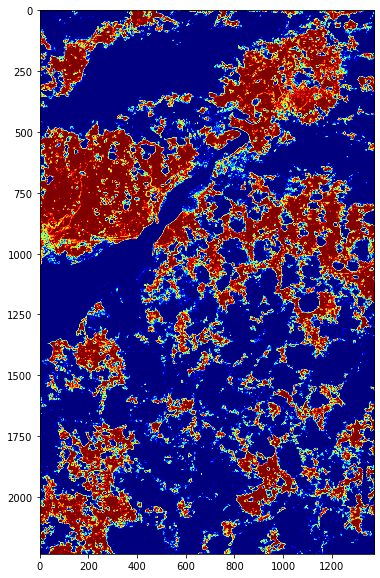

In [13]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots( figsize=(10,10) )
ax.imshow( response._df.iloc[ 3 ][ 'NDVI.tif' ][ :, :, 0 ], cmap='jet'  )

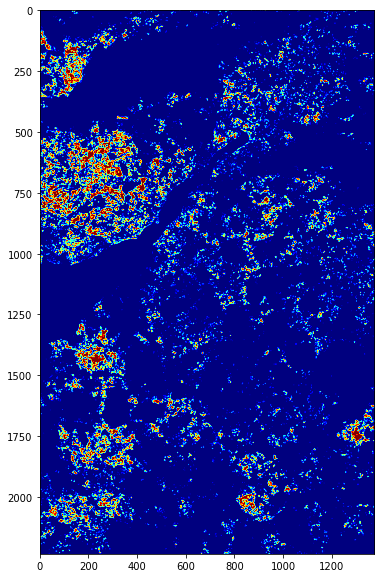

In [14]:
fig,ax = plt.subplots( figsize=(10,10) )
ax.imshow( response._df.iloc[ 3 ][ 'NDVI.tif' ][ :, :, 1 ], cmap='jet'  )

In [141]:
lcc = response._df.iloc[ 0 ][ 'LCC.tif' ]
type (lcc )

numpy.ndarray

In [142]:
int( response._bbox.crs.value )

32630

In [143]:
import numpy as np
mask = np.uint8( ( ( lcc>=111.0 ) & ( lcc <= 126.0 ) ) )
mask

array([[1, 0, 0, ..., 1, 1, 0],
       [1, 0, 0, ..., 1, 1, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 1, 1, 1],
       [0, 1, 1, ..., 1, 1, 1]], dtype=uint8)

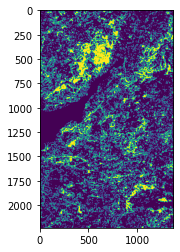

In [144]:
import matplotlib.pyplot as plt
plt.imshow( mask )

In [145]:
import affine
transform = affine.Affine.from_gdal(*response._transform)
transform

Affine(50.0, 0.0, 499999.99999999936,
       0.0, -50.0, 5761510.316555307)

In [146]:
import rasterio.features
shapes = rasterio.features.shapes(mask, transform=transform)
shapes

<generator object shapes at 0x0000021AE797D5F0>

In [147]:
import shapely.geometry as sg
import geopandas as gpd

geometries = []
colvalues = []
for (geom, colval) in shapes:
    geometries.append(sg.Polygon(geom["coordinates"][0]))
    colvalues.append(colval)

gdf = gpd.GeoDataFrame({"value": colvalues, "geometry": geometries})
gdf = gdf.set_crs( int( response._bbox.crs.value ) )

In [148]:
gdf[ 'area' ] = gdf[ 'geometry' ].area
gdf[ 'perimeter' ] = gdf[ 'geometry' ].length

In [149]:
# display 25 largest school grounds
gdf.sort_values( 'area', ascending=False ).head(25)

,value,geometry,area,perimeter
17832,0.0,"POLYGON ((500050.000 5761510.317, 503800.000 5...",7.575015e+09,872400.0
5836,1.0,"POLYGON ((534700.000 5749460.317, 534900.000 5...",2.862875e+08,412400.0
4446,1.0,"POLYGON ((563200.000 5744860.317, 563300.000 5...",5.851750e+07,127500.0
5729,1.0,"POLYGON ((561900.000 5735160.317, 562050.000 5...",5.371750e+07,207400.0
16527,1.0,"POLYGON ((559000.000 5673210.317, 559100.000 5...",5.186500e+07,171600.0
11803,1.0,"POLYGON ((547350.000 5699110.317, 547500.000 5...",4.450750e+07,163900.0
7152,1.0,"POLYGON ((513700.000 5724110.317, 513950.000 5...",3.324750e+07,158400.0
9882,1.0,"POLYGON ((518650.000 5703710.317, 518800.000 5...",3.189750e+07,134500.0
12412,1.0,"POLYGON ((511350.000 5688310.317, 511450.000 5...",2.538750e+07,123900.0
9606,1.0,"POLYGON ((552000.000 5707460.317, 552200.000 5...",2.135250e+07,101300.0


In [150]:
df = gdf[ gdf[ 'value' ] == 1 ]
df

,value,geometry,area,perimeter
0,1.0,"POLYGON ((500000.000 5761510.317, 500000.000 5...",7500.0,400.0
1,1.0,"POLYGON ((511350.000 5761510.317, 511350.000 5...",37500.0,800.0
2,1.0,"POLYGON ((513900.000 5761510.317, 513900.000 5...",15000.0,500.0
3,1.0,"POLYGON ((514550.000 5761510.317, 514550.000 5...",45000.0,1100.0
4,1.0,"POLYGON ((522150.000 5761510.317, 522150.000 5...",5000.0,300.0
...,...,...,...,...
17825,1.0,"POLYGON ((538100.000 5649860.317, 538100.000 5...",2500.0,200.0
17828,1.0,"POLYGON ((554500.000 5649860.317, 554500.000 5...",5000.0,300.0
17829,1.0,"POLYGON ((560650.000 5649860.317, 560650.000 5...",2500.0,200.0
17830,1.0,"POLYGON ((563400.000 5650660.317, 563600.000 5...",227500.0,3400.0


In [151]:
# display 25 largest school grounds
df = df.sort_values( 'area', ascending=False ).head(25)
df

,value,geometry,area,perimeter
5836,1.0,"POLYGON ((534700.000 5749460.317, 534900.000 5...",286287500.0,412400.0
4446,1.0,"POLYGON ((563200.000 5744860.317, 563300.000 5...",58517500.0,127500.0
5729,1.0,"POLYGON ((561900.000 5735160.317, 562050.000 5...",53717500.0,207400.0
16527,1.0,"POLYGON ((559000.000 5673210.317, 559100.000 5...",51865000.0,171600.0
11803,1.0,"POLYGON ((547350.000 5699110.317, 547500.000 5...",44507500.0,163900.0
7152,1.0,"POLYGON ((513700.000 5724110.317, 513950.000 5...",33247500.0,158400.0
9882,1.0,"POLYGON ((518650.000 5703710.317, 518800.000 5...",31897500.0,134500.0
12412,1.0,"POLYGON ((511350.000 5688310.317, 511450.000 5...",25387500.0,123900.0
9606,1.0,"POLYGON ((552000.000 5707460.317, 552200.000 5...",21352500.0,101300.0
2093,1.0,"POLYGON ((537300.000 5757110.317, 537400.000 5...",20580000.0,65300.0


In [152]:
df = df[ 0 : 10 ]

<AxesSubplot:>

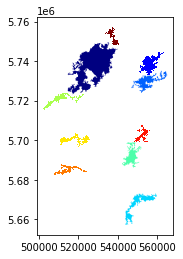

In [153]:
df.plot( cmap='jet' ) 